# 1) Factor Research & Signal Development — Earnings Quality

> Read me
- Run top-to-bottom. Uses simulated data only (numpy/pandas/matplotlib).
- Cells with **TODO** are what interviewers often expect you to implement.
- Keep runs fast. Vectorize when possible.
- Use clean functions with docstrings; add comments where you make assumptions.


## Setup & Data (simulated)

In [97]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

np.random.seed(42)

# --- Simulate panel ---
n_names = 800
n_sectors = 11
months = pd.period_range('2012-01','2020-12',freq='M')
dates = months.to_timestamp('M')
tickers = [f"U{i:04d}" for i in range(n_names)]
sectors = pd.Series(np.random.randint(0, n_sectors, size=n_names), index=tickers)

quality_level = pd.Series(np.random.normal(0, 1, n_names), index=tickers)

mi = pd.MultiIndex.from_product([dates, tickers], names=["date","ticker"])
df = pd.DataFrame(index=mi)

qtr_dates = pd.period_range('2011Q4','2020Q4',freq='Q')
qtr_ts = qtr_dates.to_timestamp('Q')
qtr_idx = pd.MultiIndex.from_product([qtr_ts, tickers], names=["date","ticker"])
fund = pd.DataFrame(index=qtr_idx)

sector_effect = pd.Series(np.random.normal(0,0.4,size=n_sectors), index=range(n_sectors))
fund["accruals"] = -0.7*quality_level.loc[fund.index.get_level_values("ticker")].values                    + sector_effect.loc[sectors.loc[fund.index.get_level_values("ticker")]].values                    + np.random.normal(0, 0.6, len(fund))

# bad code for ffill
# fund_m = (fund
#           .groupby(level="ticker")
#           .apply(lambda x: x.droplevel(0).reindex(dates, method="ffill"))
#           .swaplevel()
#           .sort_index())

fund_m = (fund['accruals']
          .unstack('ticker')             # columns = tickers
          .reindex(dates)                # index = monthly dates
          .ffill()                       # forward-fill across time per column
          .stack('ticker')               # back to MultiIndex (date, ticker)
          .to_frame('accruals')
          .sort_index())

df["accruals"] = fund_m["accruals"]
df["sector"] = sectors.loc[df.index.get_level_values("ticker")].values

market = pd.Series(np.random.normal(0.005, 0.04, len(dates)), index=dates, name="mkt")
beta = pd.Series(np.clip(np.random.normal(1.0, 0.3, n_names), 0.2, 2.0), index=tickers)
sector_shocks = pd.DataFrame(np.random.normal(0,0.02,(len(dates), n_sectors)),
                             index=dates, columns=[f"sec{i}" for i in range(n_sectors)])

# bad code to get sec_val for each stock row
# sec_cols = sector_shocks.columns
# sec_map = {i:sec_cols[i] for i in range(n_sectors)}
# sec_series = pd.Series(df["sector"].values, index=df.index)
# sec_shock_val = sector_shocks.stack()
# sec_lookup = sec_shock_val.copy()
# sec_lookup.index = pd.MultiIndex.from_tuples([(t, int(c.replace("sec",""))) for (t,c) in sec_shock_val.index])
# sec_val = sec_lookup.loc[(df.index.get_level_values("date"), sec_series.values)].values

# get sec_val for each stock row
date_idx = sector_shocks.index.get_indexer(df.index.get_level_values("date"))
sec_idx  = df["sector"].to_numpy()
# (len(df),) array of the right shape
sec_val = sector_shocks.to_numpy()[date_idx, sec_idx]

df["quality_score"] = -df["accruals"]
df["beta"] = beta.loc[df.index.get_level_values("ticker")].values

signal_strength = 0.006
idiosd = 0.06

df["ret"] = (market.loc[df.index.get_level_values("date")].values * df["beta"].values
             + 0.002*sec_val
             + signal_strength * df["quality_score"].values
             + np.random.normal(0, idiosd, len(df)))

panel = df.dropna().copy()


## TODO Checklist
1. **Winsorize** the raw factor cross-sectionally each month.
2. **Sector-standardize** (z-score within sector per month).
3. **Beta-neutralize** the factor via cross-sectional regression on beta each month.
4. Form **Q10–Q1 long–short** monthly returns; plot cumulative.
5. Compute **IC (Spearman)** and **IC decay** (1–6 months).
6. **Add turnover and a simple cost model**, and report net IR.
7. **Subperiod stability:** report metrics for 2012–2015, 2016–2020.


In [98]:
# === TODO 1–3: Build neutralized factor ===
def winsorize(s, p=0.01):
    # TODO
    low, high = s.quantile(p), s.quantile(1-p)
    s = s.clip(low, high)
    return s

def zscore(s):
    # TODO
    s = (s-s.mean())/s.std(ddof=0)
    return s

def neutralize_beta(df, factor: str, neutralizers: list):
    # TODO
    y = df[factor].values
    x = df[neutralizers].values
    X = np.c_[np.ones(len(y)), x]
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    resid = y - X@beta
    
    resid = pd.Series(resid, index=df.index)
    return resid

In [93]:
panel['factor_w'] = panel.groupby(['date', 'sector'])['quality_score'].transform(winsorize)
panel['factor_z'] = panel.groupby(['date', 'sector'])['factor_w'].transform(zscore)
norm = panel.groupby(['date', 'sector']).apply(neutralize_beta, factor='factor_z', neutralizers=['beta']).values
panel['factor_n'] = norm

/var/folders/kc/7dyzg2fs2zv9v849s3n6rd4w0000gn/T/ipykernel_31017/3838414877.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  norm = panel.groupby(['date', 'sector']).apply(neutralize_beta, factor='factor_z', neutralizers=['beta']).values


In [99]:
panel['factor_w'] = panel.groupby('date')['quality_score'].transform(winsorize)
panel['factor_z'] = panel.groupby('date')['factor_w'].transform(zscore)
norm = panel.groupby('date').apply(neutralize_beta, factor='factor_z', neutralizers=['beta'])
norm.index = norm.index.droplevel(1)
panel['factor_n'] = norm

In [100]:
# === TODO 4: Decile portfolio backtest ===
def decile_ls(panel, col, n_bins=10):
    # TODO
    panel['tile'] = panel.groupby('date')[col].transform(lambda x : pd.qcut(x.rank(method='first'), n_bins, labels=False))
    short = panel.loc[panel.tile == 0].groupby('date')['ret'].mean()
    long = panel.loc[panel.tile == 9].groupby('date')['ret'].mean()
    ls = long - short
    return ls, long, short

In [101]:
ls, long, short = decile_ls(panel, 'factor_n')

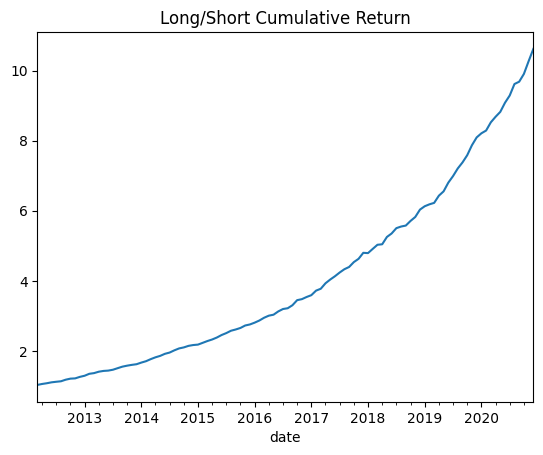

In [103]:
# TODO plot cumulative long-short return
cum = (1+ls).cumprod()
plt.figure()
cum.plot(title='Long/Short Cumulative Return')
plt.show()

In [104]:
panel

accruals  sector  quality_score      beta       ret  \
date       ticker                                                        
2012-03-31 U0000   0.308469       6      -0.308469  1.259171  0.073394   
           U0001  -1.118108       3       1.118108  0.980456 -0.174977   
           U0002   0.268108      10      -0.268108  0.764266 -0.143909   
           U0003  -0.360426       7       0.360426  0.887571 -0.021160   
           U0004  -0.272300       4       0.272300  0.941021 -0.103118   
...                     ...     ...            ...       ...       ...   
2020-12-31 U0795  -0.214648       3       0.214648  1.272744 -0.072033   
           U0796   0.702867       7      -0.702867  0.530105 -0.016162   
           U0797  -1.301655       8       1.301655  1.375817 -0.174953   
           U0798   0.285593       2      -0.285593  1.398672 -0.151651   
           U0799   0.261665       2      -0.261665  1.606236 -0.075763   

                   factor_w  factor_z  factor_n  tile  
date       ticker                                      
2012-03-31 U0000  -0.308469 -0.488087 -0.506853     3  
           U0001   1.118108  0.923165  0.924596     8  
           U0002  -0.268108 -0.448160 -0.431063     3  
           U0003   0.360426  0.173623  0.181784     5  
           U0004   0.272300  0.086443  0.090732     5  
...                     ...       ...       ...   ...  
2020-12-31 U0795   0.214648 -0.038758 -0.071526     4  
           U0796  -0.702867 -0.915293 -0.858773     2  
           U0797   1.301655  0.999698  0.954537     8  
           U0798  -0.285593 -0.516657 -0.564565     2  
           U0799  -0.261665 -0.493797 -0.566661     2  

[84800 rows x 9 columns]

In [109]:
panel

accruals  sector  quality_score      beta       ret  \
date       ticker                                                        
2012-03-31 U0000   0.308469       6      -0.308469  1.259171  0.073394   
           U0001  -1.118108       3       1.118108  0.980456 -0.174977   
           U0002   0.268108      10      -0.268108  0.764266 -0.143909   
           U0003  -0.360426       7       0.360426  0.887571 -0.021160   
           U0004  -0.272300       4       0.272300  0.941021 -0.103118   
...                     ...     ...            ...       ...       ...   
2020-12-31 U0795  -0.214648       3       0.214648  1.272744 -0.072033   
           U0796   0.702867       7      -0.702867  0.530105 -0.016162   
           U0797  -1.301655       8       1.301655  1.375817 -0.174953   
           U0798   0.285593       2      -0.285593  1.398672 -0.151651   
           U0799   0.261665       2      -0.261665  1.606236 -0.075763   

                   factor_w  factor_z  factor_n  tile  
date       ticker                                      
2012-03-31 U0000  -0.308469 -0.488087 -0.506853     3  
           U0001   1.118108  0.923165  0.924596     8  
           U0002  -0.268108 -0.448160 -0.431063     3  
           U0003   0.360426  0.173623  0.181784     5  
           U0004   0.272300  0.086443  0.090732     5  
...                     ...       ...       ...   ...  
2020-12-31 U0795   0.214648 -0.038758 -0.071526     4  
           U0796  -0.702867 -0.915293 -0.858773     2  
           U0797   1.301655  0.999698  0.954537     8  
           U0798  -0.285593 -0.516657 -0.564565     2  
           U0799  -0.261665 -0.493797 -0.566661     2  

[84800 rows x 9 columns]

In [116]:
# === TODO 5: IC and IC decay ===
# ic = ...
ics = {}
for i in range(6+1):
    tmp = panel.sort_index().copy()
    tmp['factor_lag'] = panel.groupby('date')['factor_n'].shift(i)
    ic = tmp.dropna(subset=['factor_lag', 'ret']).groupby('date').apply(lambda x : spearmanr(x.factor_lag, x.ret)[0]).mean()
    ics[i] = ic


<Axes: title={'center': 'IC Lagged'}>

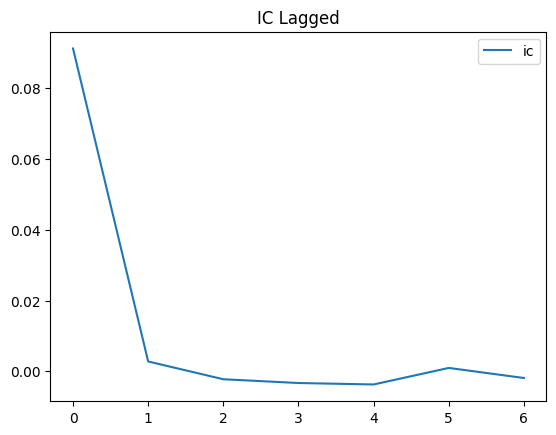

In [ ]:
pd.DataFrame(ics, index=['ic']).T.plot(title='IC Lagged')

In [ ]:
# ic_decay = {k: ... for k in range(1,7)}


In [124]:
panel

accruals  sector  quality_score      beta       ret  \
date       ticker                                                        
2012-03-31 U0000   0.308469       6      -0.308469  1.259171  0.073394   
           U0001  -1.118108       3       1.118108  0.980456 -0.174977   
           U0002   0.268108      10      -0.268108  0.764266 -0.143909   
           U0003  -0.360426       7       0.360426  0.887571 -0.021160   
           U0004  -0.272300       4       0.272300  0.941021 -0.103118   
...                     ...     ...            ...       ...       ...   
2020-12-31 U0795  -0.214648       3       0.214648  1.272744 -0.072033   
           U0796   0.702867       7      -0.702867  0.530105 -0.016162   
           U0797  -1.301655       8       1.301655  1.375817 -0.174953   
           U0798   0.285593       2      -0.285593  1.398672 -0.151651   
           U0799   0.261665       2      -0.261665  1.606236 -0.075763   

                   factor_w  factor_z  factor_n  tile  
date       ticker                                      
2012-03-31 U0000  -0.308469 -0.488087 -0.506853     3  
           U0001   1.118108  0.923165  0.924596     8  
           U0002  -0.268108 -0.448160 -0.431063     3  
           U0003   0.360426  0.173623  0.181784     5  
           U0004   0.272300  0.086443  0.090732     5  
...                     ...       ...       ...   ...  
2020-12-31 U0795   0.214648 -0.038758 -0.071526     4  
           U0796  -0.702867 -0.915293 -0.858773     2  
           U0797   1.301655  0.999698  0.954537     8  
           U0798  -0.285593 -0.516657 -0.564565     2  
           U0799  -0.261665 -0.493797 -0.566661     2  

[84800 rows x 9 columns]

In [128]:
# === TODO 6: Turnover & cost ===
# Compute weights each month; turnover vs previous; subtract cost (e.g., 30bps per 100% turnover).
dates = panel.index.get_level_values(0).unique().sort_values()
tickers = panel.index.get_level_values(1).unique().sort_values()
w = pd.Series(0, index=tickers)

In [161]:
backtest = []
for d in dates:
    snap = panel.loc[d]
    w_new = snap.factor_n / snap.factor_n.abs().sum()
    w_new -= w_new.mean() # dollar neutral
    trade = (w_new - w).abs().sum()
    print(d, trade)
    tc = trade * 0.0030
    r = (w * snap.ret).sum() - tc
    print(d, r)
    backtest.append({'date': d, 'ret': r, 'tc': tc, 'to': trade})
    w = w_new

df_backtest = pd.DataFrame(backtest)

2012-03-31 00:00:00 0.8113361760222979
2012-03-31 00:00:00 0.005527919234104155
2012-04-30 00:00:00 0.0
2012-04-30 00:00:00 0.00994073100716051
2012-05-31 00:00:00 0.0
2012-05-31 00:00:00 0.004488989590722434
2012-06-30 00:00:00 0.8374004721845141
2012-06-30 00:00:00 0.004115677654634463
2012-07-31 00:00:00 0.0
2012-07-31 00:00:00 0.003610927193469782
2012-08-31 00:00:00 0.0
2012-08-31 00:00:00 0.003928693772852993
2012-09-30 00:00:00 0.8009717537843847
2012-09-30 00:00:00 0.003282956202069019
2012-10-31 00:00:00 0.0
2012-10-31 00:00:00 0.006540031157077478
2012-11-30 00:00:00 0.0
2012-11-30 00:00:00 0.0064423666099131935
2012-12-31 00:00:00 0.8029186707128688
2012-12-31 00:00:00 0.00596234274063301
2013-01-31 00:00:00 0.0
2013-01-31 00:00:00 0.008771382853745319
2013-02-28 00:00:00 0.0
2013-02-28 00:00:00 0.013730054282702669
2013-03-31 00:00:00 0.8260345061940213
2013-03-31 00:00:00 0.001855760907419696
2013-04-30 00:00:00 0.0
2013-04-30 00:00:00 0.008692094147420084
2013-05-31 00:00

<Axes: title={'center': 'Cumulative Return After TC'}>

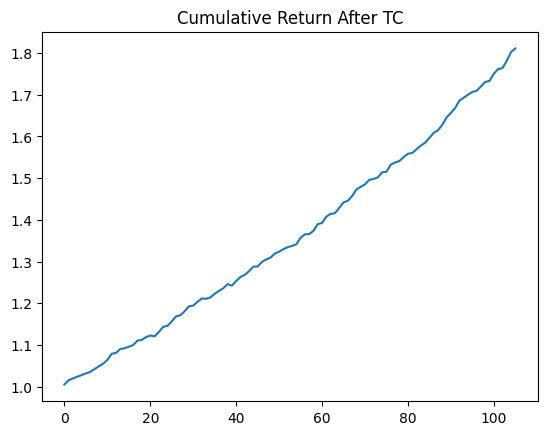

In [160]:
(1+df_backtest.ret).cumprod().plot(title='Cumulative Return After TC')

<Axes: title={'center': 'Cumulative Return After TC'}>

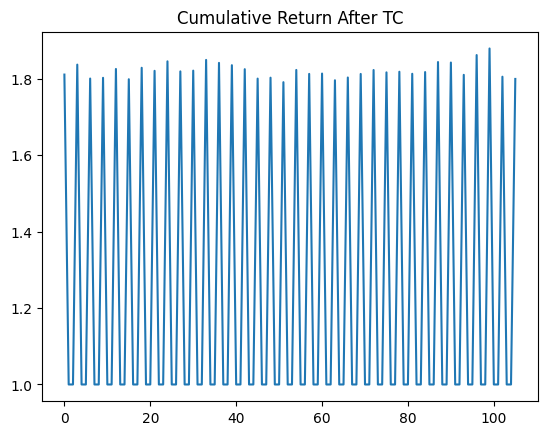

In [162]:
(1+df_backtest.to).plot(title='Cumulative Return After TC')

In [ ]:

# === TODO 7: Subperiod stability ===
# Compute IR/IC for subperiods and print a small summary table